In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# === CONFIG ===
IMAGE_DIR = r"D:\B.Tech\8th Sem\CI Lab\Project\Cylone_Intensity_IndianOcean\Infrared"
CSV_PATH = r"D:\B.Tech\8th Sem\CI Lab\Project\Cylone_Intensity_IndianOcean\label.csv"
IMG_SIZE = 64
BATCH_SIZE = 16
EPOCHS = 20
POP_SIZE = 10
NUM_GENERATIONS = 10

In [3]:
# === DATASET SETUP ===
class CycloneDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("L")  # Grayscale
        if self.transform:
            image = self.transform(image)
        vmax = self.dataframe.iloc[idx, 1]
        return image, torch.tensor(vmax, dtype=torch.float32)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

df = pd.read_csv(CSV_PATH)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = CycloneDataset(train_df, IMAGE_DIR, transform)
val_dataset = CycloneDataset(val_df, IMAGE_DIR, transform)
test_dataset = CycloneDataset(test_df, IMAGE_DIR, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [6]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === SIMPLE CNN MODEL ===
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

# === GENETIC ALGORITHM ===
def evaluate_model(model, data_loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def crossover(parent1, parent2):
    child = CNN()
    with torch.no_grad():
        for p1, p2, c in zip(parent1.parameters(), parent2.parameters(), child.parameters()):
            mask = torch.rand_like(p1) < 0.5
            c.copy_(torch.where(mask, p1, p2))
    return child

def mutate(model, mutation_rate=0.01):
    with torch.no_grad():
        for param in model.parameters():
            mutation_mask = torch.rand_like(param) < mutation_rate
            param += mutation_mask.float() * torch.randn_like(param)
    return model

def genetic_train():
    population = [CNN() for _ in range(POP_SIZE)]
    train_losses, val_losses = [], []

    for gen in range(NUM_GENERATIONS):
        start_time = time.time()
        scores = []
        for model in population:
            loss = evaluate_model(model, train_loader)
            scores.append((loss, model))

        scores.sort(key=lambda x: x[0])
        best_models = [model for _, model in scores[:POP_SIZE // 2]]

        new_population = best_models.copy()
        while len(new_population) < POP_SIZE:
            p1, p2 = np.random.choice(best_models, 2, replace=False)
            child = crossover(p1, p2)
            child = mutate(child)
            new_population.append(child)

        population = new_population
        train_loss = scores[0][0]
        val_loss = evaluate_model(scores[0][1], val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        elapsed = time.time() - start_time
        print(f"Generation {gen+1}/{NUM_GENERATIONS}: "
              f"Train Loss = {train_loss:.4f}, "
              f"Val Loss = {val_loss:.4f}, "
              f"Time = {elapsed:.2f} sec")

    return scores[0][1], train_losses, val_losses


Generation 1/10: Train Loss = 4517.5922, Val Loss = 4580.5167, Time = 856.07 sec
Generation 2/10: Train Loss = 4239.7479, Val Loss = 4301.7930, Time = 230.49 sec
Generation 3/10: Train Loss = 3320.5925, Val Loss = 3373.1266, Time = 224.21 sec
Generation 4/10: Train Loss = 3147.8262, Val Loss = 3200.6182, Time = 242.91 sec
Generation 5/10: Train Loss = 2725.1653, Val Loss = 2778.5518, Time = 334.34 sec
Generation 6/10: Train Loss = 2451.7534, Val Loss = 2488.1444, Time = 231.47 sec
Generation 7/10: Train Loss = 1203.0278, Val Loss = 1212.4119, Time = 256.12 sec
Generation 8/10: Train Loss = 1202.3330, Val Loss = 1212.4119, Time = 931.20 sec
Generation 9/10: Train Loss = 1203.2307, Val Loss = 1212.4119, Time = 455.72 sec
Generation 10/10: Train Loss = 1202.7036, Val Loss = 1212.4119, Time = 477.76 sec


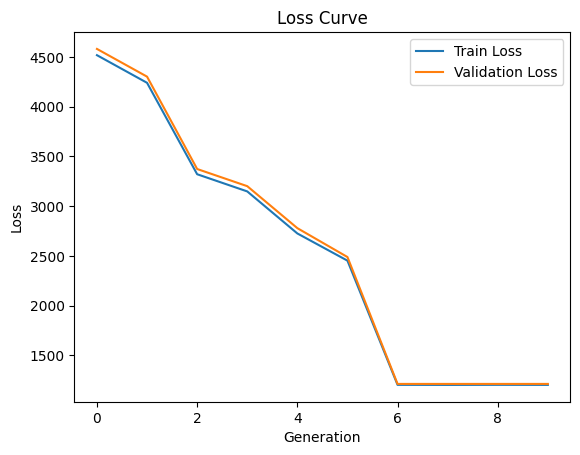

In [7]:
# === TRAINING ===
best_model, train_losses, val_losses = genetic_train()

# === LOSS PLOT ===
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [8]:
# === EVALUATION ===
def evaluate_and_print(model, loader, name):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            all_preds.extend(pred.numpy())
            all_targets.extend(y.numpy())

    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    print(f"{name} Evaluation:")
    print(f"  MSE : {mse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}")


evaluate_and_print(best_model, train_loader, "Train")
evaluate_and_print(best_model, val_loader, "Validation")
evaluate_and_print(best_model, test_loader, "Test")

Train Evaluation:
  MSE : 1202.7733
  MAE : 27.6609
  R²  : -0.0126
Validation Evaluation:
  MSE : 1208.6545
  MAE : 27.8281
  R²  : -0.0180
Test Evaluation:
  MSE : 1188.9265
  MAE : 27.3173
  R²  : -0.0088


In [10]:
# --- Save Model ---
torch.save(best_model.state_dict(), "genetic_cnn_model.pth")
print("Model saved as 'genetic_cnn_model.pth'")

Model saved as 'genetic_cnn_model.pth'


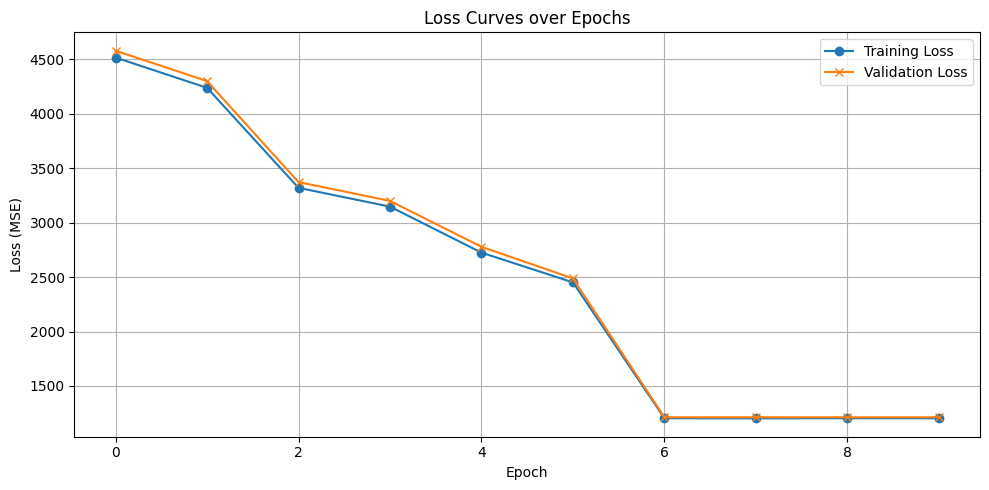

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.title("Loss Curves over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Load model architecture and weights
model = CNN()
model.load_state_dict(torch.load("genetic_cnn_model.pth"))
model.eval()

from PIL import Image
import torchvision.transforms as transforms

# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Load and preprocess image
img_path = r"D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/Infrared/IN_1.png"
image = Image.open(img_path).convert("L")
image = transform(image).unsqueeze(0)  # Add batch dimension

# Predict
with torch.no_grad():
    prediction = model(image)
    print(f"Predicted Intensity (Vmax): {prediction.item():.2f} knots")

C:\Users\satvi\AppData\Local\Temp\ipykernel_18552\3636457340.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("genetic_cnn_model.pth"))


Predicted Intensity (Vmax): 50.31 knots


In [14]:
best_model, train_losses, val_losses = genetic_train()

Generation 1/10: Train Loss = 4520.5081, Val Loss = 4584.0818, Time = 524.34 sec
Generation 2/10: Train Loss = 4375.1947, Val Loss = 4437.1031, Time = 429.49 sec
Generation 3/10: Train Loss = 4240.2276, Val Loss = 4299.2856, Time = 373.36 sec
Generation 4/10: Train Loss = 4239.4897, Val Loss = 4299.2856, Time = 377.43 sec
Generation 5/10: Train Loss = 1695.3021, Val Loss = 1709.1534, Time = 379.49 sec
Generation 6/10: Train Loss = 1414.6554, Val Loss = 1406.0168, Time = 377.29 sec
Generation 7/10: Train Loss = 1414.5810, Val Loss = 1406.0168, Time = 384.25 sec
Generation 8/10: Train Loss = 1415.1919, Val Loss = 1406.0168, Time = 397.39 sec
Generation 9/10: Train Loss = 1414.4435, Val Loss = 1406.0168, Time = 380.58 sec
Generation 10/10: Train Loss = 1414.1587, Val Loss = 1406.0168, Time = 352.28 sec


In [15]:
def genetic_train(start_gen, population, train_losses, val_losses, total_generations):
    for gen in range(start_gen, total_generations):
        start_time = time.time()
        scores = []
        for model in population:
            loss = evaluate_model(model, train_loader)
            scores.append((loss, model))

        scores.sort(key=lambda x: x[0])
        best_models = [model for _, model in scores[:POP_SIZE // 2]]

        new_population = best_models.copy()
        while len(new_population) < POP_SIZE:
            p1, p2 = np.random.choice(best_models, 2, replace=False)
            child = crossover(p1, p2)
            child = mutate(child)
            new_population.append(child)

        population = new_population
        train_loss = scores[0][0]
        val_loss = evaluate_model(scores[0][1], val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        elapsed = time.time() - start_time
        print(f"Generation {gen+1}/{total_generations}: "
              f"Train Loss = {train_loss:.4f}, "
              f"Val Loss = {val_loss:.4f}, "
              f"Time = {elapsed:.2f} sec")

    return scores[0][1], train_losses, val_losses, population


In [16]:
# Already trained for 10 generations:
# best_model, train_losses, val_losses

# Rebuild initial population from the last model
population = [best_model] + [mutate(crossover(best_model, best_model)) for _ in range(POP_SIZE - 1)]

# Continue training from generation 10 to 30
best_model, train_losses, val_losses, _ = genetic_train(
    start_gen=10,
    population=population,
    train_losses=train_losses,
    val_losses=val_losses,
    total_generations=30
)


Generation 11/30: Train Loss = 1414.7753, Val Loss = 1406.0168, Time = 182.45 sec
Generation 12/30: Train Loss = 1414.1693, Val Loss = 1406.0168, Time = 174.17 sec
Generation 13/30: Train Loss = 1414.8483, Val Loss = 1406.0168, Time = 173.39 sec
Generation 14/30: Train Loss = 1414.7749, Val Loss = 1406.0168, Time = 174.35 sec
Generation 15/30: Train Loss = 1303.5978, Val Loss = 1300.1876, Time = 173.05 sec
Generation 16/30: Train Loss = 1288.6996, Val Loss = 1294.1780, Time = 173.92 sec
Generation 17/30: Train Loss = 1288.0508, Val Loss = 1294.1780, Time = 175.10 sec
Generation 18/30: Train Loss = 1289.0097, Val Loss = 1294.1780, Time = 174.93 sec
Generation 19/30: Train Loss = 1288.9258, Val Loss = 1294.1780, Time = 174.22 sec
Generation 20/30: Train Loss = 1288.4959, Val Loss = 1294.1780, Time = 174.52 sec
Generation 21/30: Train Loss = 1288.3820, Val Loss = 1294.1780, Time = 174.35 sec
Generation 22/30: Train Loss = 1288.4548, Val Loss = 1294.1780, Time = 174.58 sec
Generation 23/30

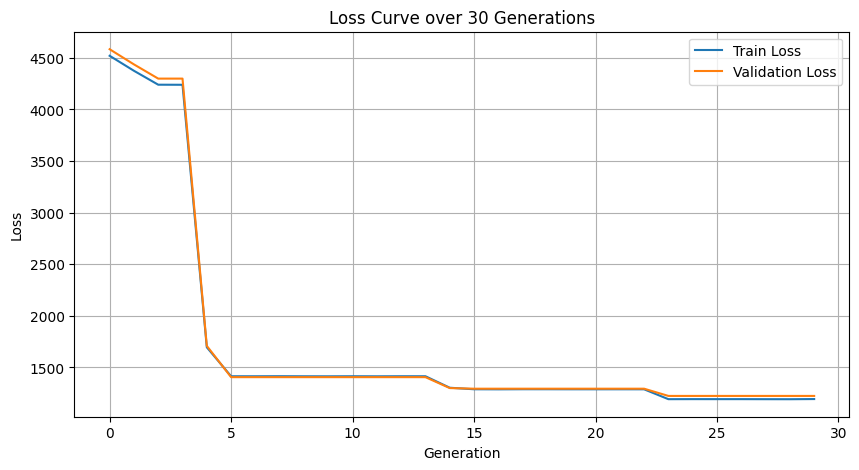

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.title('Loss Curve over 30 Generations')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Save the model
MODEL_PATH = "best_ga_cyclone_model_2.pth"
torch.save(best_model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


Model saved to best_ga_cyclone_model_2.pth


In [19]:
# === EVALUATION ===
def evaluate_and_print(model, loader, name):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            all_preds.extend(pred.numpy())
            all_targets.extend(y.numpy())

    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    print(f"{name} Evaluation:")
    print(f"  MSE : {mse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  R²  : {r2:.4f}")


evaluate_and_print(best_model, train_loader, "Train")
evaluate_and_print(best_model, val_loader, "Validation")
evaluate_and_print(best_model, test_loader, "Test")

Train Evaluation:
  MSE : 1192.6360
  MAE : 26.0745
  R²  : -0.0040
Validation Evaluation:
  MSE : 1220.5502
  MAE : 26.3615
  R²  : -0.0281
Test Evaluation:
  MSE : 1184.0386
  MAE : 25.6199
  R²  : -0.0047


In [20]:
# Load model architecture and weights
model = CNN()
model.load_state_dict(torch.load("best_ga_cyclone_model_2.pth"))
model.eval()

from PIL import Image
import torchvision.transforms as transforms

# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Load and preprocess image
img_path = r"D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/Infrared/IN_1.png"
image = Image.open(img_path).convert("L")
image = transform(image).unsqueeze(0)  # Add batch dimension

# Predict
with torch.no_grad():
    prediction = model(image)
    print(f"Predicted Intensity (Vmax): {prediction.item():.2f} knots")

Predicted Intensity (Vmax): 34.81 knots


C:\Users\satvi\AppData\Local\Temp\ipykernel_18552\3621943609.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_ga_cyclone_model_2.pt